In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time
from datetime import datetime, timedelta

[*********************100%***********************]  10 of 10 completed


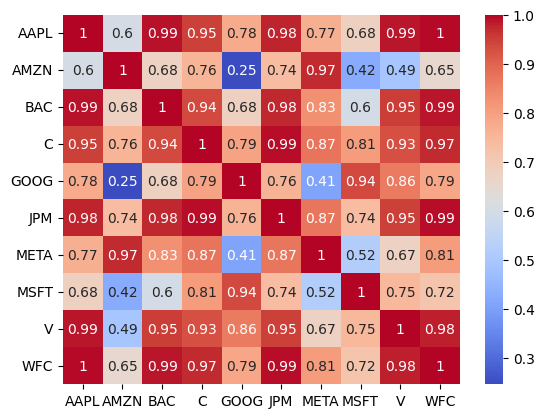

In [283]:
tickers = ['AAPL',	'AMZN',	'BAC',	'C'	,'Meta'	,'GOOG'	,'MSFT',	'JPM'	,'V'	,'WFC']
start_date = datetime.strptime("2023-03-1", "%Y-%m-%d") 
end_date = datetime.strptime("2023-03-8", "%Y-%m-%d") 
data = yf.download(tickers, start=start_date, end=end_date)
dataClose = data["Close"]
dataClose = dataClose.reset_index().drop(columns=['Date'])
returns_pct = dataClose.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
corr = returns_pct.corr() # calculate the correlations between the returns of each pair of stocks
sns.heatmap(corr,annot=True,cmap="coolwarm")
df = pd.DataFrame(corr)
titles = df.columns.tolist()

Connected Graph Found
0.8645000000000149


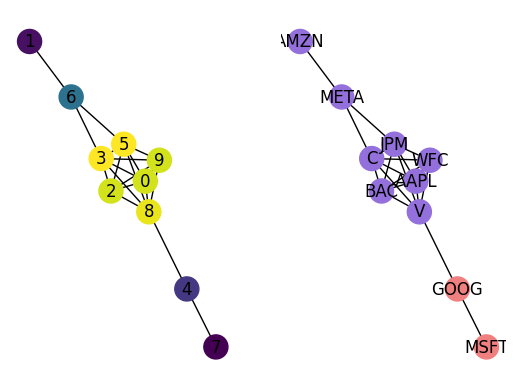

In [284]:
def truncate(f,relaxer=.99): 
    if (abs(f) < relaxer):
        return 0
    else:
        return 1
relaxer=.9999
truncated=corr.applymap(truncate)
# we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
adj = truncated- np.identity(10)
stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix

while nx.is_connected(stocknet)==False:
    relaxer=relaxer-.0001
    truncated=corr.applymap(truncate)
    adj = corr.applymap(lambda x: truncate(x, relaxer=relaxer))- np.identity(10)
    stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
else:
    print("Connected Graph Found")
    print(relaxer)

IndexedStocknet=stocknet
Indexedstock_layout = nx.spring_layout(IndexedStocknet,seed=10)
stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
L = nx.laplacian_matrix(stocknet).todense()
(u,v) = np.linalg.eig(L)
u_sorted = np.sort(u)
v_sorted = v[:, u.argsort()]
colors = [ "lightcoral" for i in range(0,10) ]
for i in range(0,10):
    if (v_sorted[i,1] < 0):
        colors[i] = "mediumpurple"


eigen_cent = nx.eigenvector_centrality(IndexedStocknet)
eigen_colors = [eigen_cent[i] for i in range(0,10)]
fig, (ax1, ax2) = plt.subplots(ncols=2)

# Draw the graphs in the subplots
nx.draw(IndexedStocknet,Indexedstock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

plt.show()

In [285]:

df = pd.DataFrame(eigen_cent,index=[0])
dfT= pd.DataFrame(titles)
# print the resulting DataFrame
mat1=df.T
mat2=dfT

joined_mat = pd.concat([mat1, mat2], axis=1)
df=joined_mat
# print the resulting joined matrix
joined_mat.head()
df.columns = ['centrality', 'stock']
df = df.iloc[:, [1, 0]]
df = df.sort_values('centrality',ascending=False)
df=df.reset_index(drop=True)
centralitydf=df

print(centralitydf)
print(centralitydf['stock'])

  stock  centrality
0     C    0.416573
1   JPM    0.416573
2     V    0.402565
3  AAPL    0.389467
4   BAC    0.389467
5   WFC    0.389467
6  META    0.167316
7  GOOG    0.080845
8  AMZN    0.032346
9  MSFT    0.015629
0       C
1     JPM
2       V
3    AAPL
4     BAC
5     WFC
6    META
7    GOOG
8    AMZN
9    MSFT
Name: stock, dtype: object


In [286]:
start_date = start_date+ timedelta(days=6)
end_date = end_date + timedelta(days=7)
#end_date = end_date.strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date)
dataOpen = data["Open"]
#print(dataOpen.head())
returns_pct = dataOpen.pct_change()
#returns_pct = returns_pct.drop(returns_pct.index[0])


[*********************100%***********************]  10 of 10 completed


In [287]:

data = returns_pct
df = pd.DataFrame(data)
#print(df)
# choose a row to compute the weighted sum of
row_to_sum = 1

# specify the weights as a list or array (here, we use equally weighted values)
weights = [1, 1/2, 1/4,1/8,1/16,1/32,1/64,1/128,1/256,1/512]

# compute the weighted sum of the row
weighted_sum = (df.iloc[row_to_sum, :] * weights).sum()

NominalReturns=weighted_sum
# print the weighted sum of the row
print(f"Return is {weighted_sum}")


Return is -0.02109725147420444


In [292]:
import pandas_datareader.data as web
import datetime as dt


end_date = start_date+timedelta(days=10)

ffr = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
latest_ffr = ffr.tail(1)['FEDFUNDS'][0]

print(latest_ffr)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [279]:

# Set the investment horizon to 1 day
investment_horizon = 1

# Get today's date
today =start_date

# Calculate the end date for the investment horizon
end_date = (datetime.today() + timedelta(days=investment_horizon)).strftime('%Y-%m-%d')

# Retrieve the daily Treasury bill yield for the investment horizon
risk_free_ticker = yf.Ticker("^IRX")
risk_free_data = risk_free_ticker.history(start=today, end=end_date)
risk_free_rate = risk_free_data["Close"][0]/100
print(risk_free_rate)

0.04837999820709229


In [714]:
ExcessReturns=NominalReturns-risk_free_rate
print(ExcessReturns)


0.0019576294631290705


In [624]:


dataOpen = dataOpen.reset_index().drop(columns=['Date'])
dataOpen.head()


,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
0,164.740005,103.910004,27.660000,45.470001,106.120003,126.800003,214.149994,285.850006,226.779999,36.500000
1,162.429993,100.750000,27.719999,45.799999,105.769997,127.000000,209.250000,283.209991,226.160004,37.110001
2,161.419998,100.959999,27.670000,45.790001,107.389999,126.540001,214.710007,289.209991,225.559998,37.700001
3,162.350006,100.800003,28.020000,46.669998,106.919998,128.300003,215.479996,285.750000,227.000000,38.770000
4,161.220001,100.400002,28.680000,47.480000,107.389999,129.179993,214.839996,284.790009,229.929993,39.419998


In [685]:
returns_pct = dataOpen.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
returns_pct.head()
#returns.head()


,AAPL,AMZN,BAC,C,GOOG,JPM,META,MSFT,V,WFC
Date,,,,,,,,,,
2023-04-11,0.005761,-0.001585,0.012649,0.019218,-0.004377,0.013909,0.003586,-0.011964,0.006384,0.028382
2023-04-12,-0.006960,-0.003968,0.023555,0.017356,0.004396,0.006859,-0.002970,-0.003360,0.012907,0.016765
2023-04-13,0.002543,-0.014442,-0.004184,-0.012216,-0.008567,-0.005574,0.004143,-0.004214,-0.002044,-0.002537
2023-04-14,0.018313,0.031531,0.025910,0.027079,0.011459,0.052078,0.009966,0.012024,0.015384,0.010936


In [686]:

# flatten the column index
#data.columns = data.columns.droplevel()

# print the modified DataFrame
#print(dataClose.head())
dataClose = dataClose.reset_index().drop(columns=['Date'])

returns_pct = dataClose.pct_change()
returns_pct = returns_pct.drop(returns_pct.index[0])
returns_pct.head()
#returns.head()



KeyError: "['Date'] not found in axis"

In [122]:
decay=1
decay_coeff=1/2
def buy_algo (centralitydf,decay,decay_coeff):
    for x in range(0,10)
        buy.df[x]*decay
        decay=decay*decay_coeff
        
def decay_optimizer():
    df=[]
    for x in np.linspace(0, 1, 10)
        df=df.append(buy_algo(cetranlitydf,decay,decay_coeff=x))
        #make code that extracts decay_coeff
        optimal=max(df)
    return optimal,  

    

SyntaxError: expected ':' (2741352801.py, line 4)

In [51]:
from scipy.optimize import minimize_scalar

# Define the function to be optimized
def my_func(x):
    return x**2 - 4*x + 3

# Set the range over which to optimize the function
x_range = (-10, 10)

# Use the minimize_scalar function to find the minimum value of the function within the given range
result = minimize_scalar(my_func, bounds=x_range)

# Print the minimum value and the value of x at which it occurs
print("Minimum value:", result.fun)
print("Optimal x value:", result.x)

Minimum value: -1.0
Optimal x value: 2.0
